# TL;DR:
* repo https://github.com/JetBrains/intellij-community
* parse methods and their names (Java) with https://github.com/tree-sitter/tree-sitter
* use base 770m-parameters CodeT5+ for estimate names prediction
* measure metrics: CER, BLEU, Accuracy
-------

# Requirements:

In [1]:
!pip install -q tree_sitter editdistance gdown wget tqdm
!pip install -q numpy pandas scikit-learn nltk editdistance
!pip install -q transformers[torch] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.2/488.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00


------
# Imports

In [2]:
import re, wget, logging, tqdm
import numpy as np
import pandas as pd
import subprocess as sp
from collections import *
from typing import *
from os.path import basename
import string

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from tree_sitter import Language, Parser

In [5]:
import torch
import transformers
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModel, Trainer, TrainingArguments
import datasets

In [6]:
import editdistance
from nltk import bleu_score

----------
# Get the sources:

In [ ]:
# to use the same version
commit_sha = "d740d6430118c2433d5a38ecc0106809bb38a76e"

In [ ]:
wget.download(f"https://github.com/JetBrains/intellij-community/archive/{commit_sha}.zip")

'intellij-community-d740d6430118c2433d5a38ecc0106809bb38a76e.zip'

In [ ]:
!unzip -qq intellij-community-{commit_sha}.zip
!mv intellij-community-{commit_sha} intellij-community

In [ ]:
files = sp.check_output(["find", "intellij-community", "-type", "f"]).decode("utf-8").split('\n')
files = [basename(f) for f in files]
cnt = Counter(f.split('.')[-1] for f in files if '.' in f)

In [ ]:
cnt.most_common(15)

[('java', 83445),
 ('kt', 57454),
 ('py', 12509),
 ('after', 12358),
 ('txt', 9329),
 ('pyi', 4493),
 ('svg', 4419),
 ('xml', 4265),
 ('html', 3724),
 ('groovy', 3168),
 ('test', 2864),
 ('iml', 1723),
 ('json', 1522),
 ('template', 1253),
 ('out', 1153)]

Here we see that the most presented language is **java**.

Also it was presented in the pretrain corpus of CodeT5+ so we can estimate the zero-shot perf of the model before the finetuning.

Let's proceed our experiments with it.

In [ ]:
code_files = sp.check_output(["find", "intellij-community", "-type", "f", "-name", "*.java"]) \
        .decode("utf-8").strip().split('\n')

# Parse method names and bodies from the code
we will use https://github.com/tree-sitter/tree-sitter for this (like the authors of CodeT5)

In [ ]:
# get the grammar
!git clone -q --depth 1 https://github.com/tree-sitter/tree-sitter-java

In [ ]:
SONAME = "build/my-languages.so"

In [ ]:
# compile the lib
Language.build_library(SONAME, ["tree-sitter-java"])

True

In [ ]:
class MethodExtractor:
    def __init__(self, soname: str):
        self.encoding = "utf-8"
        self.lang_str = "java"
        self.lang = Language(soname, self.lang_str)
        self.parser = Parser()
        self.parser.set_language(self.lang)
        self.query = self.lang.query("(method_declaration name: (identifier) @n) @m")


    def parse(self, filename: str) -> Tuple[str, int, int, int]:
        with open(filename, "rb") as ifile:
            text = ifile.read()

        tree = self.parser.parse(text)
        if tree.root_node.is_error:
            #logging.log(logging.ERROR, f"failed to parse as {self.lang_str}: '{filename}'")
            return []

        matched = self.query.captures(tree.root_node)
        result = []

        try:
            for i in range(0, len(matched), 2):
                method = matched[i][0]
                name = matched[i+1][0]
                name_start = len(method.text[:name.start_byte-method.start_byte].decode(self.encoding))
                body = matched[i][0].children[-1]
                body_start = len(method.text[:body.start_byte-method.start_byte].decode(self.encoding))
                result.append((
                    method.text.decode(self.encoding),
                    name_start,
                    name_start + len(name.text.decode(self.encoding)),
                    body_start
                ))
        except UnicodeDecodeError:
            logging.log(logging.ERROR, f"failed to process unicode in '{filename}'")
            return []

        return result

In [ ]:
def files2dataframe(files: List[str]) -> pd.DataFrame:
    me = MethodExtractor(SONAME)
    output = []
    for f in tqdm.tqdm(files):
        output += me.parse(f)

    return pd.DataFrame.from_records(
        output,
        columns="text name_left name_right body_left".split()
    )

In [ ]:
methods_df = files2dataframe(code_files)

100%|██████████| 83445/83445 [01:39<00:00, 839.42it/s]


In [ ]:
print(f"found {len(methods_df)} methods")

found 496518 methods


## remove trivial (no-body, abstract, without implementation) methods:

In [ ]:
space = re.compile(r'\s')

def nontrivial_body(row):
    body = row.text[row.body_left:]
    body = re.sub(space, "", body)
    return body not in {"", "{}", ";", "{/*...*/}", "{//...}"}

non_trivial = methods_df.apply(nontrivial_body, axis=1)
methods_df = methods_df[non_trivial]
print(f"removed {len(non_trivial)-non_trivial.sum()} trivial methods, remain: {len(methods_df)}")

removed 62812 trivial methods, remain: 433706


## remove duplicates (samples different only in spaces number):

In [ ]:
seq_space = re.compile(r"\s+")
methods_df["descriptor"] = methods_df.apply(lambda row: re.sub(seq_space, " ", row.text), axis=1)
methods_df.drop_duplicates(["descriptor"], ignore_index=True, inplace=True)
methods_df.drop("descriptor", axis=1, inplace=True)

print(f"remained: {len(methods_df)} unique methods")

remained: 384562 unique methods


## remove too long names (>64 char)

In [ ]:
non_long = methods_df.apply(lambda row: row.name_right-row.name_left <= 64, axis=1)
methods_df = methods_df[non_long]

print(f"removed {len(non_long)-non_long.sum()} long-named methods, remain: {len(methods_df)}")

removed 1452 long-named methods, remain: 383110


-------------------
shuffle and save

In [ ]:
methods_df = methods_df.sample(frac=1, random_state=7777).reset_index(drop=True)

In [ ]:
methods_df.to_csv("methods.csv")

In [ ]:
methods_df.head(3)

,text,name_left,name_right
0,"@TestMetadata(""correctVararg.kt"")\n ...",62,79
1,@Override\n public void onMessage(@NotN...,30,39
2,public void method(int anObject) {\n Sy...,12,18


# Neural net:
we will use CodeT5+ from HuggingFace hub

according to the paper, among the pretraining tasks of CodeT5+ was **Span Denoising** -- recovery of missed tokens segment. We will utilize this by giving input and output prefix in the closer form:
* at first we will replace the name of the method with `[MASK0]` special index token
* output the should have form `[MASK0] NAME` like in the pre-training
* finally, we need to patch a bit the inference process - while our "span" should be an identifier, we need to not consider hypotheses with space or other non-identifier symbol. While the net was trained on not only identifiers, just restrict the beam to id-s would cause a degradation in quality. The simple idea "let's generate a span and cut identifier from its head" works better.


In [14]:
BOS = "<s>"
MASK0 = "<extra_id_0>"
MAXLEN_INP = 256
MAXLEN_OUT = 24
# with these restrictions with cut only 7% of trainset (see below)

In [15]:
model_cpkt = 'Salesforce/codet5p-220m'

model = AutoModelForSeq2SeqLM.from_pretrained(model_cpkt, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_cpkt, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/446M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(DEVICE)
DEVICE

device(type='cuda')

------------------
## Convert to dataset:

In [ ]:
def make_str_for_t5(row):
    input_str = row.text[:row.name_left] + MASK0 + row.text[row.name_right:]
    output_str = MASK0 + row.text[row.name_left:row.name_right]
    gt_name = row.text[row.name_left:row.name_right]
    return input_str, output_str, gt_name

io_str = methods_df.apply(make_str_for_t5, axis=1, result_type='expand')
methods_df["input_str"] = io_str[0]
methods_df["output_str"] = io_str[1]
methods_df["gt_name"] = io_str[2]

In [ ]:
corpus = datasets.DatasetDict({
    "test": datasets.Dataset.from_pandas(methods_df.iloc[:2000]),
    "validation": datasets.Dataset.from_pandas(methods_df.iloc[2000:3000]),
    "train": datasets.Dataset.from_pandas(methods_df.iloc[3000:])
})

In [ ]:
corpus

DatasetDict({
    test: Dataset({
        features: ['text', 'name_left', 'name_right', 'input_str', 'output_str', 'gt_name'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'name_left', 'name_right', 'input_str', 'output_str', 'gt_name'],
        num_rows: 1000
    })
    train: Dataset({
        features: ['text', 'name_left', 'name_right', 'input_str', 'output_str', 'gt_name'],
        num_rows: 380110
    })
})

In [ ]:
corpus.save_to_disk("methods_ds")

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/380110 [00:00<?, ? examples/s]

-----------
## Infer on test set:

In [23]:
non_id = re.compile(r"[^a-zA-Z0-9$_]")

def infer(data, model):
    out_prefix = tokenizer(BOS + MASK0, return_tensors="pt", add_special_tokens=False).input_ids.to(DEVICE)

    result = []
    for row in tqdm.tqdm(data):
        inp = tokenizer(row["input_str"], max_length=MAXLEN_INP, truncation=True, return_tensors="pt").to(DEVICE)
        out = model.generate(**inp, decoder_input_ids=out_prefix, max_length=MAXLEN_OUT,
                             num_beams=4)
        out = tokenizer.decode(out[0], skip_special_tokens=True).strip()
        out = re.split(non_id, out, maxsplit=1)[0]
        result.append(out)

    return result

In [24]:
predict = infer(corpus["test"].select(range(10)), model)

100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


In [25]:
gt_names = corpus["test"][:10]["gt_name"]

In [26]:
for i in range(10):
    t = corpus["test"][i]["text"]
    if len(t) > 200:
      t = t[:200] + "..."
    print('\n'.join("### " + l for l in t.split('\n')))
    print(f"name = {gt_names[i]}\npredict = {predict[i]}\n\n")

### @TestMetadata("correctVararg.kt")
###                 public void testCorrectVararg() throws Exception {
###                     runTest("testData/inspectionsLocal/mainFunctionReturnUnit/insideObject/correctV...
name = testCorrectVararg
predict = testCorrectVararg


### @Override
###         public void onMessage(@NotNull PsiElement context, @NotNull String message) {
###           myHost.addMessage(context, message, Validator.ValidationHost.ErrorType.WARNING);
###         }
name = onMessage
predict = addError


### public void method(int anObject) {
###         System.out.println(anObject);
###         System.out.println(this.anObject);
###     }
name = method
predict = main


### private void closePreviousScenarios() {
###     closeScenario();
###     closeScenarioOutline();
###   }
name = closePreviousScenarios
predict = closeScenarioOutline


### private static void useMethodInsteadOfRedundantCall(String methodToUse, PsiMethodCallExpression redundantCall) {
###     PsiMethodCal

Not equal, yet semantically close

--------------
# Metrics:

### Accuracy
Fraction of samples with full match (hyp = ref), 1.0 = full match.
While there are multiple equally acceptable names, 100% in accuracy would not be achievend.

### Edit distance
Minimal number of operations needed to convert predicted to reference.
0 = full match.
Distance has a practical meaning if we consider generation for autocomplete (number of edits after autocompletion).

### CER (char error rate)
Edit-distance(hyp, ref) / len(ref), 0.0 = full match.
Normalized edit-distance, can be > 100% (if len(ref) < len(hyp)) but normally in [0, 1] range

### BLEU
https://en.wikipedia.org/wiki/BLEU
Fraction of mutually encountered n-grams in hyp and ref, used in machine translation.
More robust to word order change in method names.
1 = full match, 0 = no match.

In [27]:
import warnings
warnings.filterwarnings("ignore")

def measure(ref, hyp):
    acc = 0
    ed = 0
    cer = 0
    bleu = 0

    for r, h in zip(ref, hyp):
        acc += r == h
        ed_ = editdistance.eval(r, h)
        ed += ed_
        cer +=  ed_ / len(hyp)
        bleu += bleu_score.sentence_bleu([r], h)

    ed /= len(ref)
    acc /= len(ref)
    cer /= len(ref)
    bleu /= len(ref)
    return {
        "accuracy": acc,
        "editdist": ed,
        "CER": cer,
        "BLEU": bleu
    }

In [28]:
gt_names = corpus["test"]["gt_name"]
predict = infer(corpus["test"], model)

100%|██████████| 2000/2000 [14:26<00:00,  2.31it/s]


In [29]:
measure(gt_names, predict)

{'accuracy': 0.236,
 'editdist': 9.967,
 'CER': 0.004983499999999994,
 'BLEU': 0.36287926008522287}

--------------
# Finetune

for more concise training code we'll use HuggingFace transformers.Trainer.

Firstly, we need to make a PT-tensor dataset from our corpus:

In [ ]:
def extract_tokens(row):
    enc = tokenizer(row["input_str"], max_length=MAXLEN_INP, padding="max_length",
                    return_tensors="pt", truncation=True)
    labels = tokenizer(row["output_str"], max_length=MAXLEN_OUT, padding="max_length",
                       truncation=True, return_tensors="pt")["input_ids"]
    for i in range(labels.shape[0]):
        labels[i][labels[i] == tokenizer.pad_token_id] = -100
    enc["labels"] = labels
    return enc


In [ ]:
train_data = corpus.map(
    extract_tokens,
    batched=True,
    remove_columns=corpus.column_names['train'],
    load_from_cache_file=False
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/380110 [00:00<?, ? examples/s]

In [ ]:
train_data.save_to_disk("tokenized_ds")

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/380110 [00:00<?, ? examples/s]

In [ ]:
print(tokenizer.decode(train_data["train"][0]["input_ids"]))
print(tokenizer.decode([id if id != -100 else 0 for id in train_data["train"][0]["labels"]]))

<s>private void<extra_id_0>() {
    if (! myProbableIterator.hasNext()) {
      myPreCalculated = null;
    } else {
      myPreCalculated = myProbableIterator.next();
    }
  }</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

% of samples with output >= 24 tokens: 0.0036831443529504616


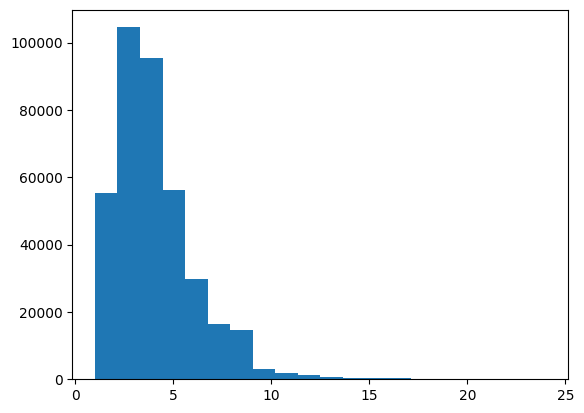

In [ ]:
outlen = train_data.with_format("torch")["train"]["labels"]
outlen = (outlen != -100).sum(axis=1).numpy()
plt.hist(outlen, bins=20);
print(f"% of samples with output >= {MAXLEN_OUT} tokens:", (outlen >= MAXLEN_OUT).mean()*100)


% of samples with input >= 256 tokens: 7.023230117597537


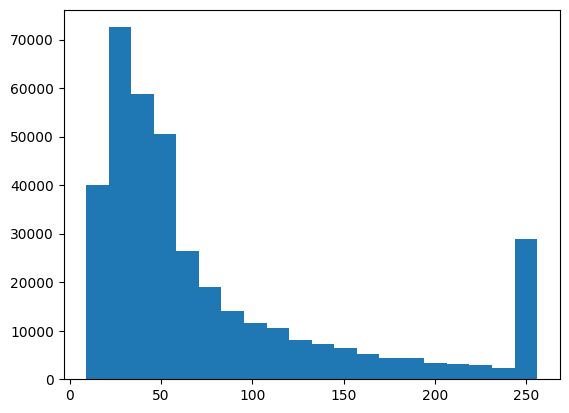

In [ ]:
inplen = train_data.with_format("torch")["train"]["input_ids"]
inplen = (inplen != 0).sum(axis=1).numpy()
plt.hist(inplen, bins=20);
print(f"% of samples with input >= {MAXLEN_INP} tokens:", (inplen >= MAXLEN_INP).mean()*100)

In [ ]:
import numpy as np
print(
    "% of total cut train samples:",
    np.logical_or((outlen >= MAXLEN_OUT), (inplen >= MAXLEN_INP)).mean()*100
)

% of total cut train samples: 7.027439425429481


---------

In [ ]:
# based on CodeT5+ (repo) fineture setup
training_args = TrainingArguments(
      report_to="tensorboard",
      output_dir="finetune",
      overwrite_output_dir=False,

      do_train=True,

      max_steps=5000, # shorter version for brief experiments on GColab
      per_device_train_batch_size=16,
      gradient_accumulation_steps=4,

      eval_steps=100,
      evaluation_strategy="steps",

      learning_rate=5e-5,
      weight_decay=0.05,
      warmup_steps=200,

      logging_dir="finetune",
      logging_first_step=True,
      logging_steps=50,
      save_total_limit=1,
      save_strategy="steps",
      save_steps=100,

      dataloader_drop_last=True,
      dataloader_num_workers=2,
      fp16=False,

      load_best_model_at_end=True,
      metric_for_best_model="eval_loss"
)

In [ ]:
# reset model (for experiments)
!rm -rf finetune
model_cpkt = 'Salesforce/codet5p-220m'
model = AutoModelForSeq2SeqLM.from_pretrained(model_cpkt, trust_remote_code=True)
model.to(DEVICE)
DEVICE

device(type='cuda')

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  train_dataset=train_data["train"],
                  eval_dataset=train_data["validation"])

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
100,1.392200,1.256332
200,1.279200,1.226859
300,1.243300,1.191378
400,1.181800,1.181262
500,1.147300,1.162560
600,1.148300,1.146077
700,1.115800,1.129950
800,1.145900,1.121999
900,1.149300,1.107351
1000,1.144300,1.096588


Step,Training Loss,Validation Loss
100,1.392200,1.256332
200,1.279200,1.226859
300,1.243300,1.191378
400,1.181800,1.181262
500,1.147300,1.162560
600,1.148300,1.146077
700,1.115800,1.129950
800,1.145900,1.121999
900,1.149300,1.107351
1000,1.144300,1.096588


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=5000, training_loss=1.0746742685317994, metrics={'train_runtime': 7081.9986, 'train_samples_per_second': 45.185, 'train_steps_per_second': 0.706, 'total_flos': 9.74332624896e+16, 'train_loss': 1.0746742685317994, 'epoch': 0.84})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.9277512431144714,
 'eval_runtime': 12.3036,
 'eval_samples_per_second': 81.277,
 'eval_steps_per_second': 10.16,
 'epoch': 0.84}

---------
Evaluate the funetuned:

In [ ]:
tuned = model
tuned.save_pretrained("tuned")

-----------
and let's measure the finetuned model:

In [32]:
gt_names = corpus["test"]["gt_name"]
predict = infer(corpus["test"], tuned)
measure(gt_names, predict)

100%|██████████| 2000/2000 [05:12<00:00,  6.40it/s]


{'accuracy': 0.4765,
 'editdist': 6.1955,
 'CER': 0.003097749999999987,
 'BLEU': 0.5857547270320025}

The accuracy increased more than **x2**

CER and BLEU enhanced **x1.5**

Seems that, firstly, our net tuned to fix minor issues in names and be more aligned with naming codestyle.

In [33]:
gt_names = corpus["test"]["gt_name"]
predict = infer(corpus["test"].select(range(10)), tuned)

100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


Let's have a look at the generated names:

In [35]:
ntr = set(corpus["train"]["gt_name"])
nte = set(corpus["test"]["gt_name"])

In [34]:
for i in range(10):
    t = corpus["test"][i]["text"]
    if len(t) > 200:
      t = t[:200] + "..."
    print('\n'.join("### " + l for l in t.split('\n')))
    print(f"name = {gt_names[i]}\npredict = {predict[i]}\n\n")

### @TestMetadata("correctVararg.kt")
###                 public void testCorrectVararg() throws Exception {
###                     runTest("testData/inspectionsLocal/mainFunctionReturnUnit/insideObject/correctV...
name = testCorrectVararg
predict = testCorrectVararg


### @Override
###         public void onMessage(@NotNull PsiElement context, @NotNull String message) {
###           myHost.addMessage(context, message, Validator.ValidationHost.ErrorType.WARNING);
###         }
name = onMessage
predict = addMessage


### public void method(int anObject) {
###         System.out.println(anObject);
###         System.out.println(this.anObject);
###     }
name = method
predict = setAnObject


### private void closePreviousScenarios() {
###     closeScenario();
###     closeScenarioOutline();
###   }
name = closePreviousScenarios
predict = closeAllScenarios


### private static void useMethodInsteadOfRedundantCall(String methodToUse, PsiMethodCallExpression redundantCall) {
###     PsiMet

---------------------

# Appendix: shortcuts with prepared data
to start from certain segment

## Load parsed methods:


In [ ]:
!gdown 1-6ssSSkOmfgMQJJPGgCcazw-ruXdGgB8
!md5sum methods.csv

Downloading...
From (original): https://drive.google.com/uc?id=1-6ssSSkOmfgMQJJPGgCcazw-ruXdGgB8
From (redirected): https://drive.google.com/uc?id=1-6ssSSkOmfgMQJJPGgCcazw-ruXdGgB8&confirm=t&uuid=4793f949-a5b8-493d-917e-e8bfcbc47fd7
To: /content/methods.csv
100% 147M/147M [00:01<00:00, 114MB/s]


In [ ]:
methods_df = pd.read_csv("methods.csv", usecols=["text", "name_left", "name_right"])
methods_df.head(3)

,text,name_left,name_right
0,"@TestMetadata(""correctVararg.kt"")\n ...",62,79
1,@Override\n public void onMessage(@NotN...,30,39
2,public void method(int anObject) {\n Sy...,12,18


## Load methods Dataset:

In [7]:
!gdown 1-2hGfnPsHliQ1Jb9499SDmCZJhaZYwHd -O methods.tar
!md5sum methods.tar
!tar -xf methods.tar

Downloading...
From (original): https://drive.google.com/uc?id=1-2hGfnPsHliQ1Jb9499SDmCZJhaZYwHd
From (redirected): https://drive.google.com/uc?id=1-2hGfnPsHliQ1Jb9499SDmCZJhaZYwHd&confirm=t&uuid=d2ed96c4-7241-489f-b5c7-d4b9ded7cc45
To: /content/methods.tar
100% 306M/306M [00:05<00:00, 59.9MB/s]
1161afab3a1ed5b7f34cfe064dedaf93  methods.tar


In [8]:
corpus = datasets.load_from_disk('methods_ds')
corpus

DatasetDict({
    test: Dataset({
        features: ['text', 'name_left', 'name_right', 'input_str', 'output_str', 'gt_name'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'name_left', 'name_right', 'input_str', 'output_str', 'gt_name'],
        num_rows: 1000
    })
    train: Dataset({
        features: ['text', 'name_left', 'name_right', 'input_str', 'output_str', 'gt_name'],
        num_rows: 380110
    })
})

## Load tokenized Dataset:

In [9]:
!gdown 1-4-sK2tHftFxZItYMGAI6wKWypOT-YmG -O tokenized.tar
!md5sum tokenized.tar
!tar -xf tokenized.tar

Downloading...
From (original): https://drive.google.com/uc?id=1-4-sK2tHftFxZItYMGAI6wKWypOT-YmG
From (redirected): https://drive.google.com/uc?id=1-4-sK2tHftFxZItYMGAI6wKWypOT-YmG&confirm=t&uuid=e304294a-3a72-4d7e-aba8-ade6cce5db78
To: /content/tokenized.tar
100% 569M/569M [00:05<00:00, 105MB/s]
bcc05fabdcad4662b469a66881187bdb  tokenized.tar


In [10]:
train_data = datasets.load_from_disk("tokenized_ds")
train_data

DatasetDict({
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 380110
    })
})

## Load finetuned model:

In [11]:
!gdown 1-6ln4koU5BeJRN1qh-KoqUjq8Q-wog8H -O tuned.tar
!tar -xf tuned.tar

Downloading...
From (original): https://drive.google.com/uc?id=1-6ln4koU5BeJRN1qh-KoqUjq8Q-wog8H
From (redirected): https://drive.google.com/uc?id=1-6ln4koU5BeJRN1qh-KoqUjq8Q-wog8H&confirm=t&uuid=2042310c-deee-4233-a020-9ab4b84965e9
To: /content/tuned.tar
100% 892M/892M [00:09<00:00, 95.8MB/s]


In [12]:
!md5sum tuned.tar

57bdca5aa6208455f3a13fd6eb0d9ff7  tuned.tar


In [31]:
tuned = AutoModelForSeq2SeqLM.from_pretrained("tuned/", local_files_only=True)
tuned.to(DEVICE)
DEVICE

device(type='cuda')

## Export data to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# upload tar-s to /content/drive/MyDrive/final-data